In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import date
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#asking the user for stock ticker, strike price, days from now
#the contract will expire to use later
#creating a function to be able to assign values to variables
try:
    ticker = str(input("Please enter a ticker symbol: "))
    strike = float(input("Enter a strike price: "))
    days_left = int(input("How many days until the contract expires? "))
except:
    print("A wrong value was given to the console.")

Please enter a ticker symbol: SPY
Enter a strike price: 12
How many days until the contract expires? 2


In [3]:
#writing function to get dataframe of first stock. will check other stocks later
try:
    df = web.DataReader(ticker, data_source='yahoo', start= ( date.today() - relativedelta(years=5) ), end=date.today())  
except:
    #making sure that the ticker the user gave was valid
    print("Ticker is invalid.")

In [4]:
#printing ticker data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-21,201.880005,200.089996,201.410004,201.669998,99094300.0,183.103790
2015-12-22,203.850006,201.550003,202.720001,203.500000,111026200.0,184.765350
2015-12-23,206.070007,204.580002,204.690002,206.020004,110987200.0,187.053391
2015-12-24,206.330002,205.419998,205.720001,205.679993,48539600.0,186.744629
2015-12-28,205.259995,203.940002,204.860001,205.210007,65899900.0,186.317932
...,...,...,...,...,...,...
2020-12-14,369.799988,364.470001,368.640015,364.660004,69216200.0,363.112183
2020-12-15,369.589996,365.920013,367.399994,369.589996,64071100.0,368.021240
2020-12-16,371.160004,368.869995,369.820007,370.170013,58420500.0,368.598816


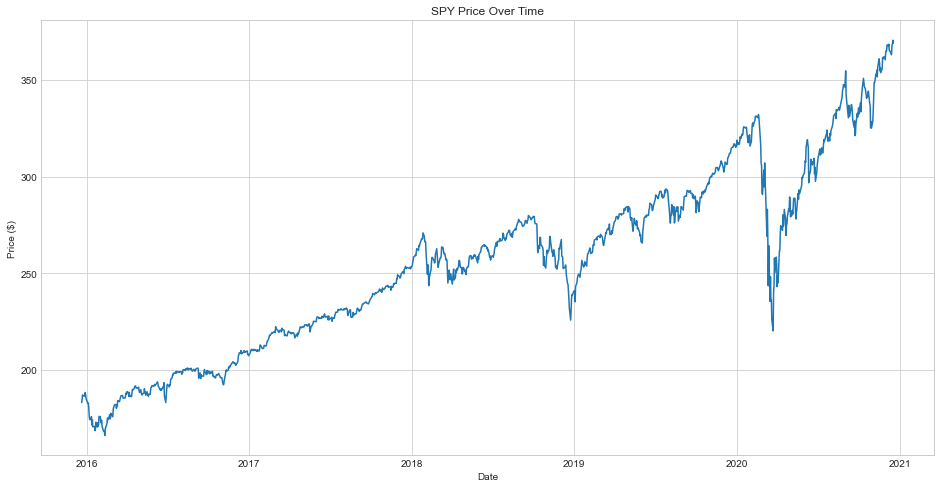

In [5]:
#showing 3 year ticker price visualization or max date
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,8))
plt.title(ticker + ' Price Over Time')
plt.plot(df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

In [6]:
#we'll only be needing the "adj close" and "date" columns, so we'll drop everything else
df.rename(columns={'Adj Close': 'price'}, inplace=True)
df.drop(['Open','High','Low',"Close",'Volume'],axis=1,inplace=True)
# making prediction model

In [7]:
#getting a value for the closing price, which is what we will predict
dataset = df.values
#scaling data between 0,1
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset.reshape(-1,1))


#Create the scaled training data set with 0.8 train length, 0.2 test
training_data_len = math.ceil(len(dataset) * 0.8)
train_data = scaled_data[0:training_data_len, : ]
#Splitting the data into x_train and y_train data sets
x_train= []
y_train = []
#here, I'll get data from the last 60 days of trading to predict the next
#prices of the underlying stock.
for i in range(60,len(train_data)):
    x_train.append(train_data[i - 60:i,0])
    y_train.append(train_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [8]:
#building the neural network for predicting stock price
model = Sequential()
#using 3 layers with 64 neurons, 0.2 dropout
#model.add(Dropout(0.05))
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
#model.add(Dropout(0.05))
model.add(LSTM(units=50))
model.add(Dense(1))
#compiling the model using an adam optimizer and mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error')
#training model
#batch: total training example
#epoch: # of iterations
model.fit(x_train, y_train,batch_size=1,epochs=1,verbose=2)

948/948 - 10s - loss: 0.0015


In [9]:
#testing data now
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
x_test = np.array(x_test)
#reshaping to 3d array
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
#un-scale the data to original form
predictions = scaler.inverse_transform(predictions)
print(predictions.shape)

(251, 1)


In [10]:
#printing rmse value
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
RMSE = rmse(predictions,y_test)
print("RMSE: " + str(RMSE) )

RMSE: 14.891710561532197


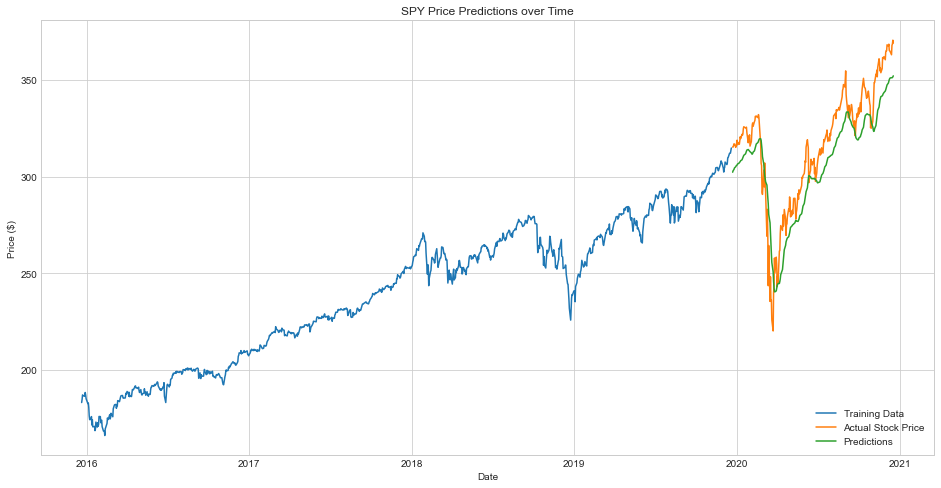

In [11]:
#Plot/Create the data for the graph
train = df.filter(['price'])[:training_data_len]
actual_price = df.filter(['price'])[training_data_len:]
actual_price['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title(ticker + " Price Predictions over Time")
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.plot(train['price'])
plt.plot(actual_price[['price', 'Predictions']])
plt.legend(['Training Data', 'Actual Stock Price', 'Predictions'], loc='lower right')
plt.show()

In [12]:
print(predictions)

[[302.3254 ]
 [303.0777 ]
 [303.77158]
 [304.5045 ]
 [305.18738]
 [305.66064]
 [306.04706]
 [306.57053]
 [306.9343 ]
 [307.2875 ]
 [307.53348]
 [307.8332 ]
 [308.2921 ]
 [308.72522]
 [309.28287]
 [309.81747]
 [310.35684]
 [311.05362]
 [311.84494]
 [312.57565]
 [313.2233 ]
 [313.80136]
 [314.0755 ]
 [313.78864]
 [313.49106]
 [313.1678 ]
 [312.93896]
 [312.3395 ]
 [311.79352]
 [311.6662 ]
 [312.03625]
 [312.72116]
 [313.39462]
 [314.203  ]
 [315.0488 ]
 [316.0053 ]
 [316.908  ]
 [317.75238]
 [318.42908]
 [319.0834 ]
 [319.55994]
 [319.65292]
 [318.72906]
 [316.6611 ]
 [314.08792]
 [310.41373]
 [306.40533]
 [303.44733]
 [300.5979 ]
 [298.99988]
 [297.40997]
 [295.64746]
 [292.27557]
 [289.37497]
 [285.87534]
 [280.53033]
 [276.13297]
 [270.45837]
 [265.49503]
 [260.3718 ]
 [255.6157 ]
 [250.7154 ]
 [245.72646]
 [242.39449]
 [240.44661]
 [240.39789]
 [240.89392]
 [242.2319 ]
 [243.65897]
 [244.23839]
 [244.68251]
 [244.74083]
 [245.70905]
 [247.10802]
 [249.26735]
 [251.97115]
 [254.59944]

In [ ]:
for count, val in enumerate(predictions):
    